<div style="display: flex; align-items: center; width: 100%;">  
  <div style="display: flex; flex-direction: column; align-items: center; justify-content: center; width: 100px; margin-right: 20px;">    
    <a href="https://risklab.ai" style="border: 0; line-height: 1;">
      <img src="../../utils/risklab_ai.gif" width="100px" style="border: 0; vertical-align: middle;"/>
    </a>
  </div>  
  <div style="flex-grow: 1;">
    <h1 style="margin: 0; font-weight: bold; text-align: left; font-size: 38px;">
      The Power of CPCV
    </h1>
  </div>  
</div>

In the previous tutorial, we used `PurgedKFold` to get a single, reliable out-of-sample (OOS) accuracy score. But this leads to a critical question:

**"How do we know we weren't just lucky?"**

A single backtest path, even a purged one, could be an outlier. `CombinatorialPurged` (CPCV) solves this. Instead of one path, it runs *many* backtest paths by combining different train/test splits. This allows us to see the **distribution** of performance metrics, giving a much more robust assessment of our strategy.

This notebook will show you how to:
1.  Run `CombinatorialPurged` (CPCV) to get *all* backtest paths.
2.  Run `BaggedCombinatorialPurged` (B-CPCV) to see the effect of bagging.
3.  Run `AdaptiveCombinatorialPurged` (A-CPCV) to see feature-based splits.
4.  Plot a histogram of these performance scores to compare their distributions.

## 0. Setup and Imports

This setup is identical to the `PurgedKFold` tutorial for consistency.

In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Third-party for data and modeling
import yfinance as yf
import ta
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# RiskLabAI Imports
from RiskLabAI.backtest.validation import CrossValidatorController
import RiskLabAI.utils.publication_plots as pub_plots

In [ ]:
# Global Plotting Settings
SAVE_PLOTS = False  
PLOT_THEME = 'dark' # Options: 'light', 'medium'. 'dark', 'light-transparent', 
PLOT_QUALITY = 300  
SAVE_DIR = 'figs'     

pub_plots.setup_publication_style(
    theme=PLOT_THEME,
    quality=PLOT_QUALITY,
    save_plots=SAVE_PLOTS,
    save_dir=SAVE_DIR
)

Matplotlib style updated. Theme: 'dark', Quality: 300 DPI.
Plot saving enabled. Saving to: 'figs'


## 1. Load Data & Generate Signals

We use the same data generation as the previous tutorial to create our `X`, `y`, and `event_times`.

In [3]:
import yfinance as yf
import pandas as pd
import ta
from ta.utils import dropna

# --- 1. Load Data ---
ticker_symbol = "SPY"
start_date = "2010-01-01"
end_date = "2025-01-01"

data = yf.Ticker(ticker_symbol).history(
    start=start_date, 
    end=end_date, 
    auto_adjust=True
)

# --- CRITICAL FIX: Remove timezone information to prevent comparison errors ---
data.index = data.index.tz_localize(None)
# -------------------------------------------------------------------

# --- 2. Generate Features (X) ---
X = pd.DataFrame(index=data.index)
X['rsi'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
X['roc'] = ta.momentum.ROCIndicator(data['Close'], window=10).roc()

# --- 3. Generate Labels (y) ---
look_forward = 20
y = data['Close'].pct_change(look_forward).shift(-look_forward)
y = pd.Series((y > 0).astype(int), name='label')

# --- 4. Define Event Times (t1) ---
event_times = pd.Series(y.index, index=y.index).apply(lambda x: x + pd.DateOffset(days=look_forward))

# --- 5. Align Data ---
all_data = pd.concat([X, y, event_times.rename('t1')], axis=1).dropna()

X = all_data.drop(columns=['label', 't1'])
y = all_data['label']
event_times = all_data['t1']

# --- NEW: Create a feature for A-CPCV ---
X_rsi_feature = X['rsi']
# --------------------------------------

print(f"--- SPY (ETF) Data Loaded (TZ-Naive) ---")
print(f"Aligned data shapes: X={X.shape}, y={y.shape}, t1={event_times.shape}")
print(X.head())

--- SPY (ETF) Data Loaded (TZ-Naive) ---
Aligned data shapes: X=(3761, 2), y=(3761,), t1=(3761,)
                  rsi       roc
Date                           
2010-01-22  27.005684 -4.361140
2010-01-25  31.251067 -4.189553
2010-01-26  29.721870 -4.724122
2010-01-27  33.673012 -3.369715
2010-01-28  29.364934 -5.278273


## 2. Define Backtest Parameters

We define the common parameters for our backtests.

* `n_splits = 10`: The data is split into 10 groups.
* `n_test_groups = 2`: Each test set will consist of 2 of these groups.

This will generate $C(10-1, 2-1) = 9$ total backtest paths.

In [4]:
n_splits = 10
n_test_groups = 2
embargo_pct = 0.01

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

print(f"Parameters defined: n_splits={n_splits}, n_test_groups={n_test_groups}")

Parameters defined: n_splits=10, n_test_groups=2


## 3. Standard CPCV (Combinatorial Purged)

First, we run the standard `CombinatorialPurged` validator. This is the baseline for our combinatorial analysis.

In [5]:
# --- 1. Instantiate the Validator ---
cv_controller_cpcv = CrossValidatorController(
    validator_type='combinatorialpurged',
    n_splits=n_splits,
    n_test_groups=n_test_groups,
    times=event_times,
    embargo=embargo_pct
)
cv_cpcv = cv_controller_cpcv.get_validator()

# --- 2. Run All Backtest Paths --- 
print(f"Running Standard CPCV... (This may take a moment)")
paths_preds_cpcv = cv_cpcv.backtest_predictions(
    estimator=model,
    data=X,
    labels=y,
    n_jobs=-1 # Parallelize the training of C(10,2) = 45 estimators
)

print(f"Backtest complete.")
print(f"Received {len(paths_preds_cpcv)} backtest paths.")

Running Standard CPCV... (This may take a moment)
Backtest complete.
Received 9 backtest paths.


## 4. Evaluate the Distribution of Performance

`paths_preds_cpcv` is a dictionary where each key is a path ID and each value is the OOS prediction array for that path.

We can now calculate the accuracy for *each path* and see the full distribution of our model's performance.

**NOTE:** The accuracy calculation here is fixed. We must `dropna()` from the prediction series first, as it's sparse, and *then* align `y`.

In [6]:
path_accuracies_cpcv = []

print("Calculating accuracy for each CPCV path...")
for path_name, predictions in paths_preds_cpcv.items():
    
    # --- BUG FIX: Correctly score sparse predictions ---
    # 1. Create series from array, aligned with original index
    pred_series = pd.Series(predictions, index=y.index)
    
    # 2. Drop NaNs (samples not in a test set for this path)
    pred_series = pred_series.dropna()
    
    # 3. Align the true labels to the prediction index
    y_true = y.loc[pred_series.index]
    
    # 4. Calculate accuracy
    acc = accuracy_score(y_true, pred_series)
    # -----------------------------------------------------
    
    path_accuracies_cpcv.append(acc)
    print(f"  {path_name}: Accuracy = {acc * 100:.2f}%")

path_accuracies_cpcv = pd.Series(path_accuracies_cpcv, name='CPCV')

Calculating accuracy for each CPCV path...
  Path 1: Accuracy = 60.49%
  Path 2: Accuracy = 60.25%
  Path 3: Accuracy = 59.77%
  Path 4: Accuracy = 60.57%
  Path 5: Accuracy = 59.77%
  Path 6: Accuracy = 60.14%
  Path 7: Accuracy = 60.41%
  Path 8: Accuracy = 61.95%
  Path 9: Accuracy = 60.62%


## 5. Bagged CPCV (B-CPCV)

Now we run the `BaggedCombinatorialPurged` validator. This applies a BaggingClassifier *wrapper* to each of the $C(n,k)$ estimators, helping to reduce variance.

In [7]:
# --- 1. Instantiate the B-CPCV Validator ---
cv_controller_bcpvc = CrossValidatorController(
    validator_type='baggedcombinatorialpurged',
    n_splits=n_splits,
    n_test_groups=n_test_groups,
    times=event_times,
    embargo=embargo_pct,
    # Bagging-specific params
    n_estimators=10,      # Number of bags per split
    max_samples=0.5,      # 50% of samples per bag
    random_state=42,
    classifier=True
)
cv_bcpvc = cv_controller_bcpvc.get_validator()

# --- 2. Run All Backtest Paths --- 
print(f"Running Bagged CPCV (B-CPCV)... (This may take a moment)")
paths_preds_bcpvc = cv_bcpvc.backtest_predictions(
    estimator=model, # The base estimator for bagging
    data=X,
    labels=y,
    n_jobs=-1
)
print(f"B-CPCV complete.")

Running Bagged CPCV (B-CPCV)... (This may take a moment)
B-CPCV complete.


In [8]:
path_accuracies_bcpvc = []
print("Calculating accuracy for each B-CPCV path...")
for path_name, predictions in paths_preds_bcpvc.items():
    pred_series = pd.Series(predictions, index=y.index).dropna()
    y_true = y.loc[pred_series.index]
    acc = accuracy_score(y_true, pred_series)
    path_accuracies_bcpvc.append(acc)

path_accuracies_bcpvc = pd.Series(path_accuracies_bcpvc, name='B-CPCV')

Calculating accuracy for each B-CPCV path...


## 6. Adaptive CPCV (A-CPCV)

Finally, we run `AdaptiveCombinatorialPurged`. This advanced validator adjusts the split boundaries based on an `external_feature`. We will use the **RSI** we calculated earlier as our feature. This will make the splits non-uniform, creating test sets based on market regime (e.g., high/low RSI).

In [9]:
# --- 1. Instantiate the A-CPCV Validator ---
cv_controller_acpcv = CrossValidatorController(
    validator_type='adaptivecombinatorialpurged',
    n_splits=n_splits,
    n_test_groups=n_test_groups,
    times=event_times,
    embargo=embargo_pct,
    # Adaptive-specific params
    external_feature=X_rsi_feature, # Use RSI to guide splits
    n_subsplits=5, # Finer granularity for adjustment
    lower_quantile=0.3,
    upper_quantile=0.7
)
cv_acpcv = cv_controller_acpcv.get_validator()

# --- 2. Run All Backtest Paths --- 
print(f"Running Adaptive CPCV (A-CPCV)... (This may take a moment)")
paths_preds_acpcv = cv_acpcv.backtest_predictions(
    estimator=model,
    data=X,
    labels=y,
    n_jobs=-1
)
print(f"A-CPCV complete.")

Running Adaptive CPCV (A-CPCV)... (This may take a moment)
A-CPCV complete.


In [10]:
path_accuracies_acpcv = []
print("Calculating accuracy for each A-CPCV path...")
for path_name, predictions in paths_preds_acpcv.items():
    pred_series = pd.Series(predictions, index=y.index).dropna()
    y_true = y.loc[pred_series.index]
    acc = accuracy_score(y_true, pred_series)
    path_accuracies_acpcv.append(acc)

path_accuracies_acpcv = pd.Series(path_accuracies_acpcv, name='A-CPCV')

Calculating accuracy for each A-CPCV path...


## 7. Results Comparison

Now we plot the histograms of all three combinatorial methods. We can clearly see how **B-CPCV** narrows the distribution, reducing the variance of the outcomes and giving us a more reliable estimate of the *true* mean performance.

NameError: name 'sns' is not defined

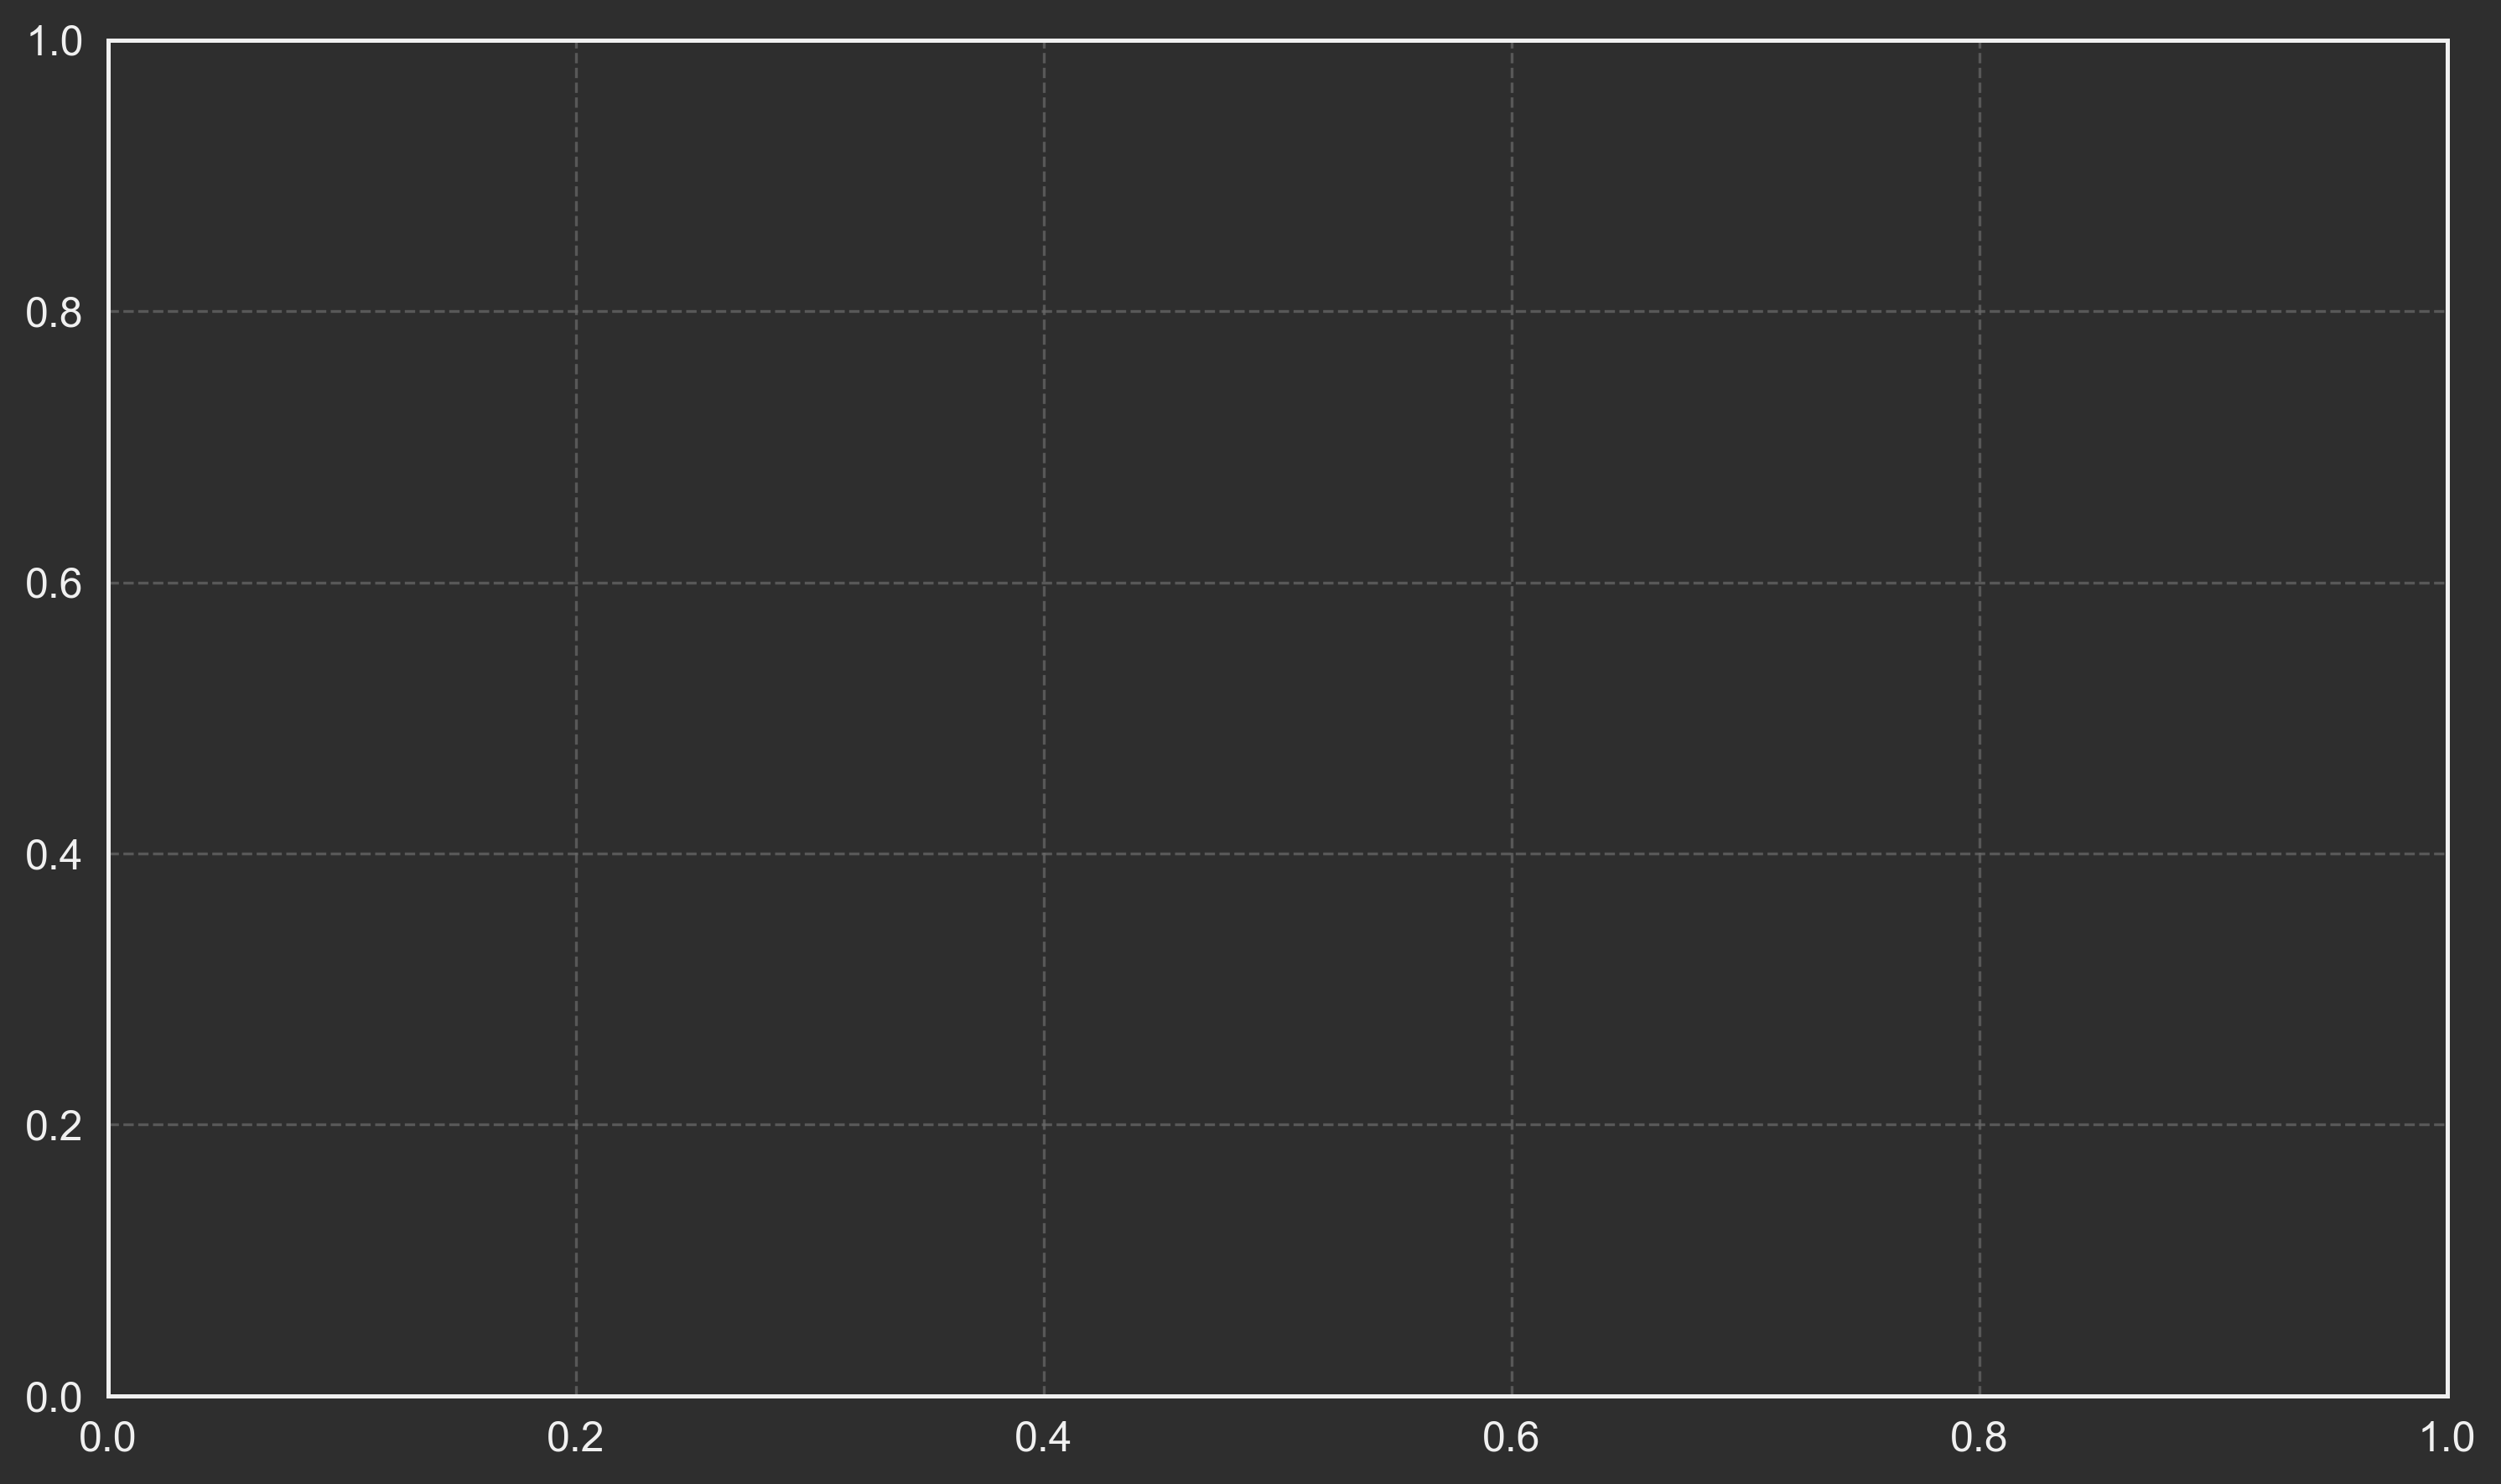

In [11]:
fig, ax = plt.subplots(figsize=(12, 7))

# Plot all three distributions
sns.histplot(path_accuracies_cpcv, ax=ax, alpha=0.6, label='Standard CPCV', kde=True, stat='density')
sns.histplot(path_accuracies_bcpvc, ax=ax, alpha=0.6, label='Bagged CPCV (B-CPCV)', kde=True, stat='density', color='#f37735')
sns.histplot(path_accuracies_acpcv, ax=ax, alpha=0.6, label='Adaptive CPCV (A-CPCV)', kde=True, stat='density', color='#d11141')

# Add mean lines
ax.axvline(path_accuracies_cpcv.mean(), color='blue', linestyle='--', lw=2, label=f'CPCV Mean: {path_accuracies_cpcv.mean()*100:.2f}%')
ax.axvline(path_accuracies_bcpvc.mean(), color='orange', linestyle='--', lw=2, label=f'B-CPCV Mean: {path_accuracies_bcpvc.mean()*100:.2f}%')
ax.axvline(path_accuracies_acpcv.mean(), color='red', linestyle='--', lw=2, label=f'A-CPCV Mean: {path_accuracies_acpcv.mean()*100:.2f}%')

# Apply standard styling
pub_plots.apply_plot_style(
    ax=ax,
    title=f'Comparison of Combinatorial CV Path Accuracies (k={len(path_accuracies_cpcv)} paths)',
    xlabel='Out-of-Sample Accuracy',
    ylabel='Density',
    legend_title='CV Method' # Give the legend a title
)

# Finalize (show and/or save)
plt.tight_layout()
pub_plots.finalize_plot(fig, 'cpcv_accuracy_comparison.png')

print("--- Summary Statistics ---")
summary_df = pd.DataFrame({
    'CPCV': path_accuracies_cpcv.describe(),
    'B-CPCV': path_accuracies_bcpvc.describe(),
    'A-CPCV': path_accuracies_acpcv.describe()
})
display(summary_df.to_markdown(floatfmt=".4f"))